# Stablo odlučivanja

>U ovoj svesci je prikazan primer korišćenja stabla odlučivanja, modela mašinskog učenja pod nadzorom koji se obučava sa cijem da verodostojno proceni binarni ishod procesa na osnovu niza kategorijalnih parametara.

Kod mašinskog učenja sa višedimenzionalnim podacima gde je bitno na procenimo "koliko" će nečega biti na izlazu, najčešće primenjujemo linearnu regresiju. Sa druge strane, kod mašinskog učenja sa istim takvim podacima gde je bitno da procenimo "da li" će nečega biti ili neće, često se koristi stablo odlučivanja. Postoje različite varijante i nadogradnje stabla odlučivanja (npr. _random forest_), ali se sve svode na jednostavnu ideju – da postavljamo prava da/ne pitanja i da svakim pitanjem podelimo posmatranu grupu na dve homogenije grupe, približno iste veličine koje imaje različite vrednosti na izlazu.

U ovoj svesci ćemo analizirati skup podataka "Titanik" koji se često koristi kao primer za stablo odlučivanja. U tom skupu podataka se nalaze osnovne karakteristike putnika, npr. pol, godine, mesto gde su se ukracali itd., dok je binarni podatak koji pokušavamo da procenimo da li su preživeli brodolom ili ne. Ono što znamo o brodolomu Titanika bez gledanja u tabelu jeste da se približno 60% od oko 1300 putnika utopilo. Koje biste vi pitanje postavili o karakteristikama putnika pa da bitno poboljšate procenu da li su preživeli ili ne? Ispostavlja se da je najbolji prediktor pol putnika. Ako je muškog pola verovatno nije preživeo (19%), ako je ženskog pola verovatno jeste (73%). Sada ćemo da analiziramo skup podataka i utvrdimo koja su to prava pitanja.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

Osim standardnih biblioteka koje su nam potrebne za rad u Pajtonu, ovde ćemo uvesti i neke potrebne funkcije iz biblioteke __sklearn__ za mašinsko učenje.  

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import tree

In [3]:
data = pd.read_csv('data/titanic.csv')
data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,3.0,0.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3.0,0.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3.0,0.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,NaN,C,NaN,NaN,NaN
1308,3.0,0.0,"Zimmerman, Mr. Leo",male,29.0000,0.0,0.0,315082,7.8750,NaN,S,NaN,NaN,NaN


Za početak, vidimo da je na Titaniku bilo 1310 putnika, ali da za jednog, poslednjeg na listi, ništa ne znamo. Razumno je isključiti taj red tabele jer sa njim ništa ne možemo da uradimo.

In [4]:
data.drop(1309,axis=0,inplace=True)

Sada da vidimo šta su nam podaci po kolonama.

Opis promenljivih, odnosno kolona u tabeli __data__:

    - pclass (putnička klasa, odnosno paluba)
    - survived (da li je putnik preživeo ili ne): 0 = ne, 1 = da
    - name (ime)
    - sex (pol)
    - age (godine)
    - sibsp (broj članova porodice na brodu ne računajući roditelje ili decu)
    - parch (broj rotelja ili dece na brodu)
    - ticket (broj karte)
    - fare (cena karte)
    - cabin (broj kabine)
    - embarked (mesto ukrcavanja): C = Cherbourg, Q = Queenstown, S = Southampton
    - boat (čamac za spasavanje)
    - body (broj identifikovanog tela)
    - home.dest (odredište)

Nisu sve ove promenljive neophodne ili smislene za procenu da li je putnik preživeo. Npr. ako je bio u određenom čamcu za spasavanje, onda je preživeo. Svejedno, cilj ove vežbe je da napravimo jednostavan model. Zato ćemo isključiti većinu kolona sa nepotrebnim podacima. Pre toga ćemo napraviti brzu eksplorativnu analizu kako bismo znali šta od kolona treba da zadržimo.

Otprilike polovina kolona sadrži tekstualne podatke, a polovina numeričke.

## Brza eksplorativna analiza

Postoji li veza između palube na kojoj su bili putnici i uspešnosti preživaljavanja? Verovatno da. Pomoću funkcije `crosstab()` ćemo ukrstiti podatke o preživelima i palubama na kojima su bili.

In [5]:
pd.crosstab(data['survived'],data['pclass'])

pclass,1.0,2.0,3.0
survived,,,
0.0,123,158,528
1.0,200,119,181


Vidimo da je većina sa prve palube preživela dok sa druge i posebno treće palube nisu. Ovu kolonu ćemo sačuvati. Pitanje "Da li je putnik bio na prvoj palubi?" sigurno je jedno od onih koja mogu da povećaju uspešnost procene preživljavanja. 

Za pol smo još u uvodu rekli da je dobar prediktor. Da vidimo kolika je ta razlika.

In [6]:
pd.crosstab(data['survived'],data['sex'])

sex,female,male
survived,,
0.0,127,682
1.0,339,161


Nema sumnje da ovu kolonu treba zadržati. Imamo samo mali tehnički problem. Drvo odlučivanja u biblioteci __sklearn__ zahteva da podaci budu brojevi. Zato ćemo morati da mapiramo podatke tako da umesto "male" stavimo 0, a umesto "female" 1. Za to ćemo koristi funkciju `map()` čiji je argument _dictionary_ sa nizom parova koji određuju šta se u šta mapira.

In [7]:
sex_mapping = {"male": 0, "female": 1}
data['sex'] = data['sex'].map(sex_mapping)

In [8]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",1,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",0,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",1,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",0,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Sledeća promenljiva koja sigurno ima veze sa verovatnoćom preživljavanja je starost putnika. U principu, mogli bismo da ostavimo tu kolonu takvu kakva jeste, ali rezulat ne bi bio naročito smislen. Stabla odlučivanja pretpostavljaju da su numerički podaci ordinalni, odnosno da postoji neka monotona veza između broja i uticaja na traženu procenu. Logično, prvo su decu spašavali i tu je stopa preživljavanja najveća, ali verovatnoća spašavanja ne opada monotono sa godinama. Zato ovo nije dobar primer ordinalne promenljive.

In [9]:
bins = [0, 15, 30, 45, 60, np.inf]
names = ['0-14', '15-29', '30-44', '45-59', '60+']
godine = pd.cut(data['age'], bins, labels=names)
pd.crosstab(data['survived'],godine)

age,0-14,15-29,30-44,45-59,60+
survived,,,,,
0.0,49,312,165,68,25
1.0,66,182,117,54,8


Umesto ordinalne skale možda je bolje da uzmemo samo jedan podatak za koji imamo nekakvo objašnjenje, npr. da uvedemo dodatnu promenljivu __child__ koja bi bila binarna. Ako je dete onda je vrednost 1, ako nije onda je 0.

In [10]:
child=np.where(data.age<15,1,0)

In [11]:
data['child']=child

Veza između broja rođaka i preživljavanja opet nije linearna.

In [12]:
pd.crosstab(data['survived'],data['sibsp'])

sibsp,0.0,1.0,2.0,3.0,4.0,5.0,8.0
survived,,,,,,,
0.0,582,156,23,14,19,6,9
1.0,309,163,19,6,3,0,0


In [13]:
pd.crosstab(data['survived'],data['parch'])

parch,0.0,1.0,2.0,3.0,4.0,5.0,6.0,9.0
survived,,,,,,,,
0.0,666,70,56,3,5,5,2,2
1.0,336,100,57,5,1,1,0,0


Primećuje je se da su oni koji imaju nula rođaka najugroženiji. Čini se logično. Oni koji nemaju nikog bliskog u kriznim trenucima sigurno imaju manje šanse da prežive. Možemo da objednimo promenljive __sibsp__ i __parch__ i da vidimo ko je sam na brodu. Drugim rečima, da uvedemo novu binarnu promeljivu __alone__ za one koji su sami.

In [14]:
alone=np.where(data.sibsp + data.parch==0,1,0)

In [15]:
data['alone']=alone

Ostale promenljive kao što su ime, odredište ili oznaka kabine verovatno imaju još manje efekta pa ih nećemo uzimati za dalju analizu.

In [16]:
data=data[['survived','pclass','sex','child','alone']]

In [17]:
data

,survived,pclass,sex,child,alone
0,1.0,1.0,1,0,1
1,1.0,1.0,0,1,0
2,0.0,1.0,1,1,0
3,0.0,1.0,0,0,0
4,0.0,1.0,1,0,0
...,...,...,...,...,...
1304,0.0,3.0,1,1,0
1305,0.0,3.0,1,0,0
1306,0.0,3.0,0,0,1
1307,0.0,3.0,0,0,1


Primetite da su neke vrednosti memorisane kao celobrojne, a neke kao decimalne. To je za stablo odlučivanja svejedno jer će ih sve tretirati kao decimalne.

In [18]:
data.corr()

,survived,pclass,sex,child,alone
survived,1.000000,-0.312469,0.528693,0.110204,-0.201719
pclass,-0.312469,1.000000,-0.124617,0.118383,0.147393
sex,0.528693,-0.124617,1.000000,0.070430,-0.284537
child,0.110204,0.118383,0.070430,1.000000,-0.332270
alone,-0.201719,0.147393,-0.284537,-0.332270,1.000000


Koeficijent korelacije između pojedinih promenljivih govori o tome koliko su dobri prediktori za preživljavanje, ali i tome u kakvoj su međusobnoj vezi. Npr. postoji primetna veza između promeljivih __child__ i __alone__ i ona ima negativnu korelaciju. Zvuči logično. Deca ne bi trebalo da su na brodu sama bez ikog svog. Za naš model predikcije to govori nešto drugo, odnosno da prejaka veza između dve promenljive kvari model i da bi možda jednu od njih trebalo isključiti.

Konačno, možemo da izaberemo karakteristike koje hoćemo kao nezavisno promenljive u modelu. __X__ će biti tabela samo sa tim kolonama, a __y__ kolona u kojoj su podaci o tome da li su preživeli.

## Obučavanje modela

In [19]:
features = ['pclass','sex','child','alone']
X = data.loc[:,features]
y = data.loc[:,'survived']

Pomoću funkcije `train_test_split()` iz biblioteka __sklearn.model__ ćemo podeliti __X__ i __y__ na deo za obučavanje i deo za testiranje u odnosu 75:25.

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.25)

Osnovni stabla odlučivanja je klasifikator. Ovde prvo kreiramo jedan takav objekat pod imenom __clf__, a onda ga obučavamo na pripremljenim podacima za obuku. Kriterijumi za klasifikaciju i načini realizacije mogu biti razni. Podrazumevani kriterijum je "gini". Njegove vrednosti će kasnije biti prikazivane na dijagramu. Za sada je važno samo da ograničimo maksimalni broj deljenja stabla (_max_depth_) ili minimalni uzorak koji može da se deli (_min_samples_split_). Ovo je važno da bismo izbegli _over-fitting_ efekat. Model koji previše dobro fituje na podacima za obuku, pravi velike greške na podacima za testiranje.

In [21]:
clf = DecisionTreeClassifier(min_samples_split=100, max_depth=3)#
clf = clf.fit(X_train,y_train)

## Testiranje modela

Sada kada imamo obučen (ili istreniran) model možemo da ga primenimo na podacima koje smo ostavili za testiranje (__X_test__), dobijemo procene __y_pred__ i da ih onda uporedimo sa stvarnim vrednostima (__y_test__). U oba niza su nule i jedinice. Kako da izmerimo koliko je dobro preklapanje između njih?

In [22]:
y_pred = clf.predict(X_test)

Za uspešnost predikcije postoje različite metrike: tačnost, preciznost itd. Ipak, uspešnost predikcije, u opštem slučaju, ne može da se prikaže samo jednim brojem. Nas bi trebalo da interesuje koliko su zastupljene sve četiri kombinacije: 
1. da je putnik preživeo i da je predikcija bila da je preživeo (_true positive_, TP),
2. da je putnik preživeo i da je predikcija bila da nije preživeo (_false negative_, FN),
3. da putnik nije preživeo i da je predikcija bila da nije preživeo (_true negative_, TN) i
4. da putnik nije preživeo i da je predikcija bila da je preživeo (_false positive_, FP).

Samo jedan od ovih brojeva može da nas dovede u zabludu. Npr. model koji kaže da su svi preživeli bi imao 100% uspešnost u proceni kod onih koji su preživeli, ali 0% kod onih koji nisu. To ne bi bio posebno dobar model. 

Umesto jednog broja za opisivanje uspešnosti predikcije, obično se koristi matrica konfuzije (_confusion matrix_). U matrici su frekvencije sve četiri gore pomenute kombinacije ishoda.

| |0|1|
|---|---|---|
|__nije preživeo__|TN|FP|
|__preživeo__|FN|TP|

Idealan model bi trebalo da ima vrednosti samo po glavnoj dijagonali, tj. TP i FN. To bi značilo da se predikcija 0 uvek poklapa sa "nije preživeo", a 1 sa "preživeo".

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[169,  21],
       [ 57,  81]], dtype=int64)

Kada bismo ovo malo lepše formatirali, imali bismo _DataFrame_ sa odgovarajućim vrednostima.

In [24]:
pd.DataFrame(cm,index=['nije preživeo','preživeo'])

,0,1
nije preživeo,169,21
preživeo,57,81


Idealni model bi imao samo _true positive_ i _true negative_ vrednosti. Takav model bi imao tačnost 100%.
Tačnost (_accuracy_) se definiše kao zbir vrednosti po glavnoj dijagonali podeljen sa zbirom svih vrednosti u matrici konfuzije, tj. $accuracy=\frac{TP+TN}{TP+TN+FP+FN}$.


In [25]:
acc=metrics.accuracy_score(y_test, y_pred)
print(f"Tačnost: {acc:.3f}") # formatiran ispis sa tri decimale

Tačnost: 0.762


Poređenja radi, kada bismo samo na osnovu frekvencije preživljavanja u skupu podataka za obuku, bez ikakvog kriterijuma, slučajno dodeljivali vrednost __1__ sa verovatnoćom $p=\frac{broj\hspace{.1cm}preživelih}{ukupan\hspace{.1cm}broj\hspace{.1cm}putnika}$ tačnost bi trebalo da bude oko 0.53. Mala odstupanja od ove vrednosti su moguća zbog malog uzorka i stohastičnosti izbora.

In [26]:
y_dummy=np.where(np.random.random_sample(size=len(y_test))<sum(y_train)/len(y_train),1,0)
acc0=metrics.accuracy_score(y_test, y_dummy)
print(f"Tačnost (bez kriterijuma): {acc0:.3f}")

Tačnost (bez kriterijuma): 0.476


## Vizuelizacija stabla odlučivanja

Uprkos tome što smo obučili i testirali stablo odlučivanja, mi i dalje ne znamo kako ono izgleda. Teorijski uvek postoji čvor koji se deli na dve grane, pa te dve na četiri, četiri na osam itd. Nas svakako interesuje koje je promenljive i koje kriterijume algoritam koristio da izvrši grananje i koliko dobra podela u svakom od tih čvorova u kojima se odvija grananje. Detalje stabla odlučivanja kao što su promenljive po kojim delimo uzorak, koji je bio kriterijum za deljenje, kolika je veličina uzorka i kakva raspodela unutar uzorka prema izlaznoj vrednosti možemo da vidimo kao tekstualni zapis za svaki čvor pomoću funkcije `export_text()`.

In [27]:
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_1 <= 0.50
|   |--- feature_2 <= 0.50
|   |   |--- feature_0 <= 1.50
|   |   |   |--- class: 0.0
|   |   |--- feature_0 >  1.50
|   |   |   |--- class: 0.0
|   |--- feature_2 >  0.50
|   |   |--- class: 1.0
|--- feature_1 >  0.50
|   |--- feature_0 <= 2.50
|   |   |--- feature_0 <= 1.50
|   |   |   |--- class: 1.0
|   |   |--- feature_0 >  1.50
|   |   |   |--- class: 1.0
|   |--- feature_0 >  2.50
|   |   |--- feature_3 <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- feature_3 >  0.50
|   |   |   |--- class: 1.0



Složićemo se lako da ovaj način prikazivanja nije najpregledniji. Kako je napravljeno ovo naše stablo odlučivanja, najbolje ćemo videti ako ga prikažemo grafički pomoću funkcije `plot_tree()`.

Prvi čvor, odakle sve kreće, uzima ceo uzorak za učenje. Tu algoritam bira promenljive i njihove vrednosti koje su najbolje deljenje podatka po izabranom kriterijumu. U našem primeru je to podela prema polu putnika. Za predikciju da li je putnik preživeo ili ne, prvo najvažnije pitanje je kog je pola putnik. To piše u prvom čvoru grafičke reprezentacije mada je to zapisano na malo čudan način (sex<=0.5). Iako ovaj uslov izgleda neobično, nije ga teško protumačiti. Pošto je numerička oznaka za muški pol 0, a za ženski 1, onda manje od 0.5 znači da se stablo grana tako da na levo ide uzorak sa muškarcima, a na desno sa ženama. Uslovi za dalje grananje su da li je dete (leva grana) i da li je na trećoj palubi (desna strana). Za ostale to takođe možete da vidite.

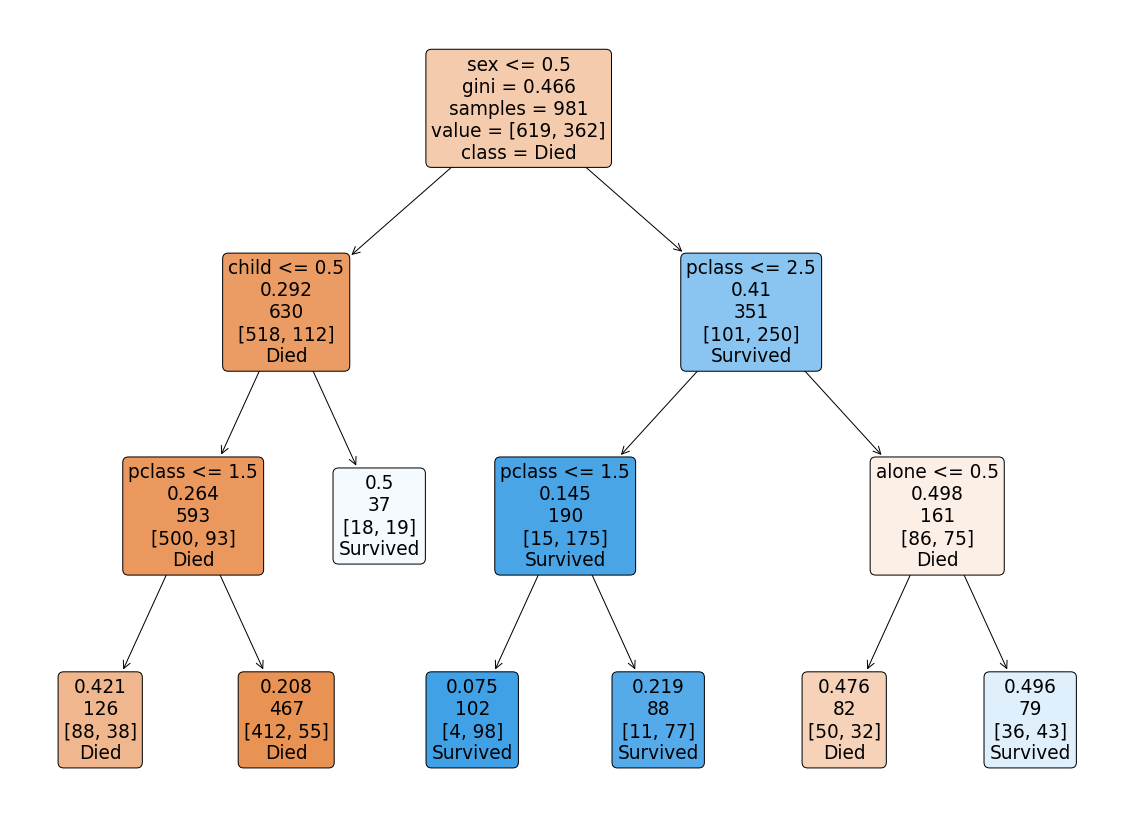

In [28]:
fig = plt.figure(figsize=(20,15))
tp = tree.plot_tree(clf, 
                   feature_names=features,
                   impurity=True, # entropy
                   label='root', 
                   class_names=['Died', 'Survived'],
                   #precision=2,
                   rounded=True,
                   filled=True)


Boje pravougaonika kojima su opisani čvorovi odgovaraju čistoći uzorka, odnosno raspodeli ishoda za taj konretan uzorak. Ako niko nije preživeo, pravougaonik će biti crven. Ako su svi preživeli, biće plav. Beo je ako jednih i drugih ima podjednako. U idealnom slučaju, stablo odlučivanja vodi do niza crvenih i plavih pravougaonika koje nema smisla dalje deliti. 

Najbolji izbor promenljivih za mašinsko učenje ne mora da bude isti za različite modele. Štaviše, ne mora da budu isti ni za jedan model ako je uzorak drugačiji ili ako se primene različiti kriterijumi. Svejedno, najznačajniji faktori će uvek biti prepoznati. Stablo odlučivanja, odnosno funkcija `feature_importances_` prikazuje koliki je udeo koje promenljive u proceni ishoda.

In [29]:
clf.feature_importances_

array([0.23771463, 0.70344829, 0.0484044 , 0.01043269])

Grafički to možemo ovako da prikažemo.

<BarContainer object of 4 artists>

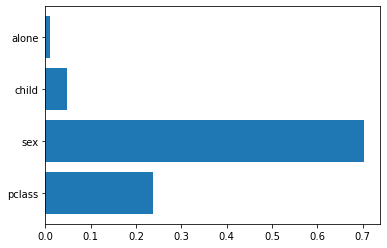

In [30]:
plt.barh(features,clf.feature_importances_)

Iako bi bilo logično da je važan faktor u predikciji preživljavanja to da li je putnik dete ili ne, on je važan samo kod male grupe putnika. 91% putnika na Titaniku nisu bili deca ispod 15 godina. Zato je značaj ovog faktora relativno mali.